In [1]:
from collections import OrderedDict
import swmmAPI as swmm
import mbc

SWMM Input File

In [2]:
swmmINP = 'NoWestside_withISDs_RainEvents.inp'
# swmmINP = 'NoWestside_withISDs_RainEvents_NoControl.inp'
simNotes = ['flood elevation control test']

In [3]:
# With or without control?
control = True

In [4]:
# Convert datum?
offset = -479.755 # To Detroit datum

Save Your Shit

In [5]:
pickleOut = 'datum_test.p'
metaCSV = 'CC_FV_FREUD_meta.csv'

Read Control Points from CSV files
CSV files are the files that should be changed

In [6]:
cF = 'input_files/ControlPoints_Init_CC_FV_FREUD.csv'
uF = 'input_files/Upstream_Init_CC_FV_FREUD.csv'
dF = 'input_files/Downstream_Init_CC_FV_FREUD.csv'
pF = 'input_files/PerformancePoints_Init.csv' # Elements of interest in SWMM to analyze performance

controlDict = swmm.return_inputs(cF,'control')
upstreamDict = swmm.return_inputs(uF,'upstream')
downstreamDict = swmm.return_inputs(dF,'downstream')
performanceDict = swmm.return_inputs(pF,'performance')
dsKeys = list(downstreamDict.keys())

Process swmm elements into a dictionary. Just provide the input file str and the swmm input section headers.

In [7]:
headers = [
    '[TITLE]',
    '[OPTIONS]',
    '[EVAPORATION]',
    '[RAINGAGES]',
    '[SUBCATCHMENTS]',
    '[SUBAREAS]',
    '[INFILTRATION]',
    '[JUNCTIONS]',
    '[OUTFALLS]',
    '[STORAGE]',
    '[CONDUITS]',
    '[PUMPS]',
    '[ORIFICES]',
    '[WEIRS]',
    '[XSECTIONS]',
    '[LOSSES]',
    '[CONTROLS]',
    '[INFLOWS]',
    '[DWF]',
    '[HYDROGRAPHS]',
    '[RDII]',
    '[CURVES]',
    '[TIMESERIES]',
    '[PATTERNS]',
    '[REPORT]',
    '[TAGS]',
    '[MAP]',
    '[COORDINATES]',
    '[VERTICES]',
    '[POLYGONS]',
    '[SYMBOLS]',
    '[PROFILES]'
]

sections = swmm.make_sections(swmmINP,headers)
conduitDict,junctionDict,storageDict,subcatchmentDict,outfallDict,orificeDict,curvesDict,pumpDict,optionsDict,raingauges,timeseries,evaporation,infiltration,losses,controls,inflows = swmm.prep_dicts(sections)

Get depth and flow information from swmm element dictionaries

In [8]:
swmm.get_depth(upstreamDict,conduitDict,storageDict)
swmm.get_depth(downstreamDict,conduitDict,storageDict)
swmm.get_q_full_and_other(downstreamDict,conduitDict,storageDict)
swmm.orifice_xsect_grab(controlDict,orificeDict)
swmm.pump_curve_grab(controlDict,pumpDict)

timestep = optionsDict['ROUTING_STEP']

swmm.performance_elements(
    performanceDict,
    conduitDict,
    junctionDict,
    storageDict,
    subcatchmentDict,
    outfallDict,
    orificeDict
)

dsKeys = list(downstreamDict.keys())

Variable Management

In [9]:
try:
    del conduitDict
    del junctionDict
    del storageDict
    del subcatchmentDict
    del outfallDict
    del orificeDict
    del curvesDict
    del pumpDict
    del optionsDict
    del sections
except:
    pass

In [10]:
print('Upstream: ', upstreamDict.keys())
print('Downstream: ', downstreamDict.keys())
print('Control: ', controlDict.keys())

Upstream:  odict_keys(['17311', '5220', '5010', '1509', 'RC1954', '1520', '2020', '2150', '2180', '2190', '2198', '2220', '2750', '2525', '2360'])
Downstream:  odict_keys(['2909', '1503', '20100', '21450', '27450'])
Control:  odict_keys(['ORIFICE33@17312-17313', 'PUMP44@5220-5219', 'PUMP34@5010-5009', 'ISD002_DOWN', 'ISD003_DOWN', 'ISD004_DOWN', 'ISD005_DOWN', 'ISD006_DOWN', 'ISD007_DOWN', 'ISD008_DOWN', 'ISD009_DOWN', 'ISD010_DOWN', 'ISD011_DOWN', 'ISD012_DOWN', 'ISD013_DOWN'])


In [11]:
upstreamDict['17311']['uparam'] = 1.0

upstreamDict['5220']['uparam'] = 1.0

upstreamDict['5010']['uparam'] = 1.0
downstreamDict['2909']['max_depth'] = 24.0

downstreamDict['2909']['max_depth'] = 22.0
downstreamDict['2909']['set_point'] = 0.8
downstreamDict['2909']['epsilon'] = 9.0
downstreamDict['2909']['gamma'] = 0.0

In [13]:
%%time
price, PDemand = mbc.run_control_sim(control,controlDict,upstreamDict,downstreamDict,dsKeys,swmmINP,performanceDict,timestep,offset)

# Save That Shit

In [17]:
saveDict = {
    'controlDict':controlDict,
    'upstreamDict':upstreamDict,
    'downstreamDict':downstreamDict,
    'metaCSV':metaCSV,
    'pickleOut':pickleOut,
    'notes':simNotes,
    'file':swmmINP,
    'control':str(control),
    'performanceDict':performanceDict
}

try:
    saveDict['price'] = price
    saveDict['PDemand'] = PDemand
except:
    pass

mbc.save_that_shit(saveDict)

# Visualize That Shit

In [12]:
index = []
for a in range(0,10):
    for b in range(0,10):
        index.append('output_files/one_inch_' + str(a) + '_' + str(b) + '.p')

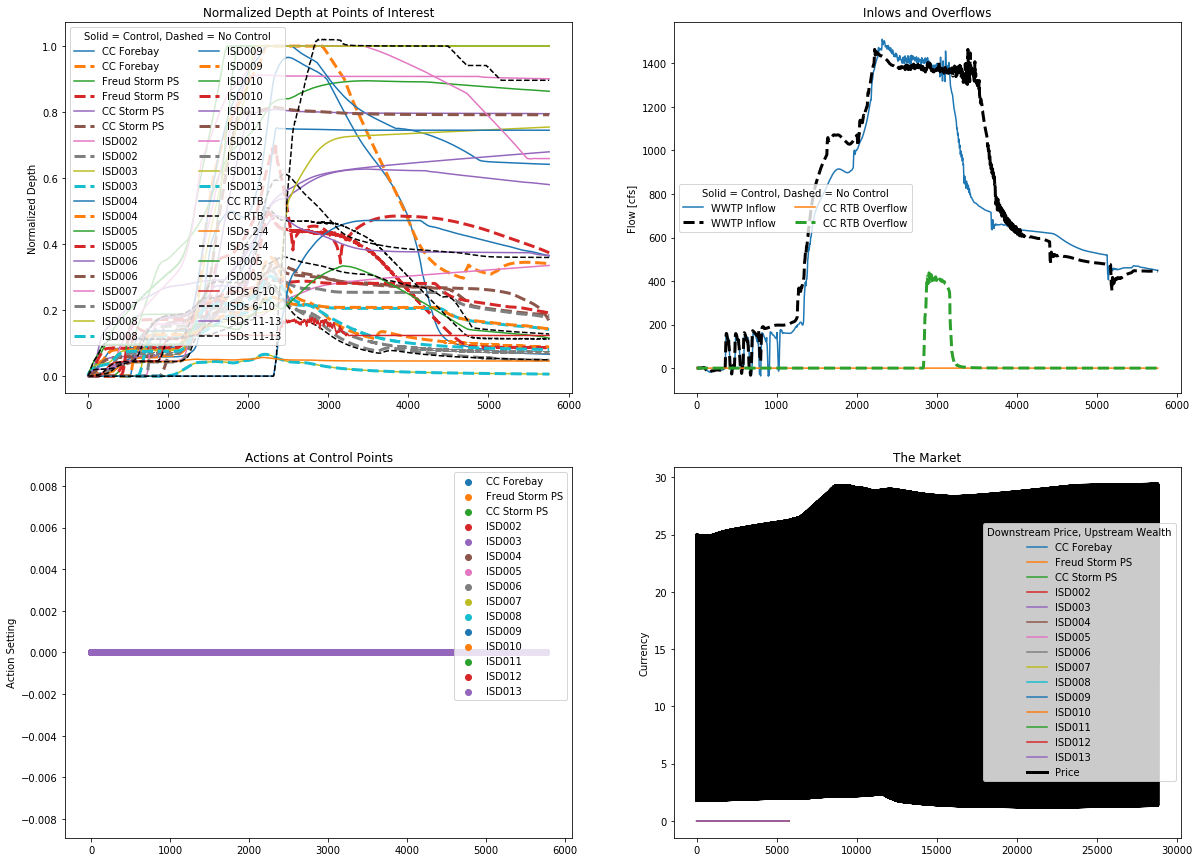

In [18]:
index = ['With_Dams_2.p']
import pickle
%matplotlib inline
f_nocontrol = 'NoControl_WithOtherPerformanceLocs.p'
control = True

for fname in index:
    f_control = fname
    figname = fname[:-2]+'.png'
    save = True
    mbc.viz_shit(f_nocontrol,f_control,figname,save,control)

In [26]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

f_nocontrol = 'NoControl_one_inch.p'
f_control = 'output_files/With_Dams_1.p'
save = False

with open(f_control,'rb') as fC, open(f_nocontrol,'rb') as fNC:
        data_control = pickle.load(fC)
        data_nocontrol = pickle.load(fNC)
